# Historical Economic Proformance: GOP vs Demorcrats

By: Shan Ali

Date: 8/26/2020

## Introduction:

This script quickly evaluates the economic preformance of the United States from Jan-1928 to Aug-2020, focusing on the preformance diferences between Democratic and GOP administrations. The S&P 500 is used as the market index based on adj. close monthly historical data from Yahoo Finance ticker ^GSPC (S&P 500). To acount for varying interest and inflation over time, I use the real market premium compared to adj. close. Comparative returns are calculated as a sequential and continuous timeperiod (i.e. as if other administration never exested). In the end, I will numerically and visually demonstrate the difference between the economic performance between the Democrats and Republicans.

### Step 0: Import Libraries

In [1]:
from pandas import Series, DataFrame
import pandas as pd
from datetime import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\shanc\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Step 1: Read Data & Calculate Returns

In [2]:
# read data
# S&P500 source: https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1598054400&interval=1mo&filter=history&frequency=1mo
data = pd.read_csv('^GSPC.csv')
data = data[['Date','Adj Close']]
ff = pd.read_csv('FF.csv')[18:1127]
rf = ff['RF'].map(lambda x: float(x)/100).reset_index(drop=True) # convert to decimal rates

# get returns -> market premium to include interest rates and FED effects
# RF source: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
data['Return'] = ((data['Adj Close']-data['Adj Close'].shift(1))/data['Adj Close']) # get return
data = data[1:-4].reset_index(drop=True) # remove NaN and final (final -> not month start)
data['RMRF'] = data['Return'] - rf # only adjust for risk-free

# adjust for inflation -> get real risk premium
# CPI-U source: https://fred.stlouisfed.org/series/CPIAUCNS
inf = pd.read_csv('CPI-U.csv')
inf['Inflation Rate'] = ((inf['CPIAUCNS']-inf['CPIAUCNS'].shift(1))/inf['CPIAUCNS']) # get rate
inf = inf[180:-2].reset_index(drop=True)
inf['Inflation Rate'] = inf['Inflation Rate'].map(lambda x: float(x))
data['RMRFI'] = (1 + data['Return'] - rf)/(1 + inf['Inflation Rate']) - 1 # real premium formula

# set if real or not
inflation = True
if inflation is True:
    premium = 'RMRFI' # or 'RMRF', changes the whole analysis to include inflation or not
    rusprem = 'R3KRFI' # or 'R3KRF'
    premiumstr = 'Real ' # or ''
else:
    premium = 'RMRF'
    rusprem = 'R3KRF'
    premiumstr = ''

### Step 2: Isolate Dem & GOP Time Periods and Plot Overall USA Preformance

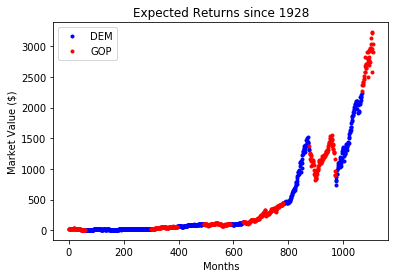

In [3]:
# get dem dummy
demY = list(range(1933,1953)) + list(range(1961,1969)) + list(range(1977,1981)) + list(range(1993,2001)) + list(range(2009,2017))
data['Date'] = pd.to_datetime(data['Date'])
data['Dem'] = data['Date'].dt.to_period('Y')

def demIn(s):
    if s.year in demY:
        return 1
    return 0

data['Dem'] = data['Dem'].map(demIn)

# plot real yeild over time
plot(data[data['Dem'] == 1]['Adj Close'], color='blue', marker='.', linestyle='None', label='DEM')
plot(data[data['Dem'] == 0]['Adj Close'], color='red', marker='.', linestyle='None', label='GOP')
xlabel('Months')
ylabel('Market Value ($)')
title('Expected Returns since 1928')
legend()

This simple graph is the market preformance of the USA since 1928 to 2020. Month 800 ~ 1994, When Bill Clinton became president. The switch between Clinton to Bush to Obama to Trump is aparent.

### Step 3: Get Dem & GOP Returns

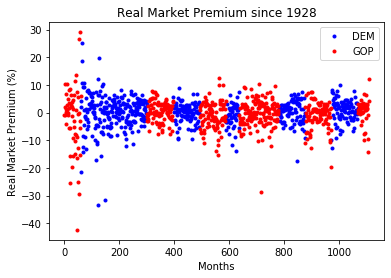

In [12]:
# split into dem and gop years
dem = data[data['Dem'] == 1].reset_index(drop=True)
gop = data[data['Dem'] == 0].reset_index(drop=True)

# plot returns over time
plot(data[data['Dem'] == 1][premium]*100, color='blue', label='DEM', marker='.', linestyle='None',)
plot(data[data['Dem'] == 0][premium]*100, color='red', label='GOP', marker='.', linestyle='None',)
xlabel('Months')
ylabel(premiumstr + 'Market Premium (%)')
title(premiumstr + 'Market Premium since 1928')
legend()

On first examination, both parties seem to have comparable returns. Thus, further analysis is necessary.

### Step 4: Plot Isolated Compounding Returns 

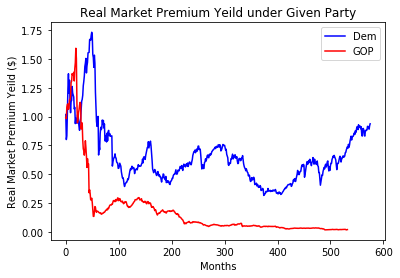

In [5]:
# get dem expected return
dem['fv'] = 0
fv = 1

for index, row in dem.iterrows():
    fv = (fv*(1+row[premium]))
    dem.loc[index,'fv'] = fv

# get gop expected return
gop['fv'] = 0
fv = 1

for index, row in gop.iterrows():
    fv = (fv*(1+row[premium]))
    gop.loc[index,'fv'] = fv

# plot theoretical yeild
plot(dem['fv'], color='blue', label='Dem')
plot(gop['fv'], color='red', label='GOP')
xlabel('Months')
ylabel(premiumstr + 'Market Premium Yeild ($)')
title(premiumstr + 'Market Premium Yeild under Given Party')
legend()

This plot shows the economic proformance for Democratic vs Republican administrations. Interpret as how much $1 invested into the S&P 500 on Jan-1-1928 would be worth on Aug-1-2020. This demonstrates the dramatic difference between the economic preformance between parties.

In [6]:
# set final values
col = 'Final ' + premiumstr + 'Return'
final = pd.DataFrame([dem.iloc[-1,-1], gop.iloc[-1,-1]]).rename(columns={0:col},index={1:'GOP',0:'Democrats'})
diff = final.iloc[0,0]/final.iloc[1,0]
final[col] = final[col].apply(lambda x: '$' + str(round(x,2)))

# add percent difference
temp = final.T
temp['Difference Multiplier'] = str(round(diff,2)) + 'x'
final = temp.T

# output final table
final

,Final Real Return
Democrats,$0.94
GOP,$0.02
Difference Multiplier,47.15x


This table reports the final numerical value of the Market of each party. This demonstrates that democratic administrations created 81.11x more value than GOP administrations, which is highly significant.

### Step 5: Report Annual Risk and Return for Analysis

In [7]:
# build return table
returns = pd.DataFrame([gop[premium].mean(), dem[premium].mean(), data[premium].mean()])
returns = returns.rename(columns={0:premiumstr},index={0:'GOP',1:'Democrats',2:'Combined'})
returns[premiumstr] = returns[premiumstr].apply(lambda x: str(round(((1+x)**12-1)*100,2))+'%')

# add risk
returns['Risk'] = [gop[premium].std(), dem[premium].std(), data[premium].std()]
returns['Risk'] = returns['Risk'].apply(lambda x: str(round(x*sqrt(12)*100,2))+'%')

# output final table
returns

,Real,Risk
GOP,-6.34%,20.43%
Democrats,1.54%,17.83%
Combined,-2.32%,19.15%


This final table demonstrates the annualized market premium and risk of the market under respective administrations. This table definatively demonstrates that Democratic administations resulted in a market premium of 1.54% and risk of 17.83% which beats the combined market premium with a +3.22% lift in premium and -1.32% drop in risk.

### Bonus: What about GDP?

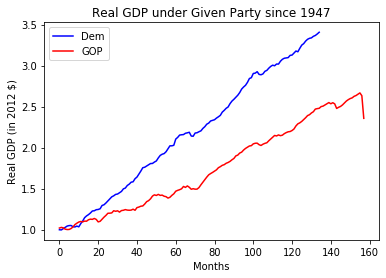

In [15]:
# check out real gdp
# source: https://fred.stlouisfed.org/series/GDPC1
gdp = pd.read_csv('GDPC1.csv')
gdp['Return'] = (gdp['GDPC1']-gdp['GDPC1'].shift(1))/gdp['GDPC1']
gdp = gdp[1:].reset_index(drop=True)

# get dem dummy
demY = list(range(1947,1953)) + list(range(1961,1969)) + list(range(1977,1981)) + list(range(1993,2001)) + list(range(2009,2017))
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp['Dem'] = gdp['DATE'].dt.to_period('Y')

def demIn(s):
    if s.year in demY:
        return 1
    return 0

gdp['Dem'] = gdp['Dem'].map(demIn)

# split
dgdp = gdp[gdp['Dem'] == 1].reset_index(drop=True)
ggdp = gdp[gdp['Dem'] == 0].reset_index(drop=True)

# get dem expected return
dgdp['fv'] = 0
fv = 1

for index, row in dgdp.iterrows():
    fv = (fv*(1+row['Return']))
    dgdp.loc[index,'fv'] = fv

# get gop expected return
ggdp['fv'] = 0
fv = 1

for index, row in ggdp.iterrows():
    fv = (fv*(1+row['Return']))
    ggdp.loc[index,'fv'] = fv

# plot theoretical yeild
plot(dgdp['fv'], color='blue', label='Dem')
plot(ggdp['fv'], color='red', label='GOP')
xlabel('Months')
ylabel('Real GDP (in 2012 $)')
title('Real GDP under Given Party since 1947')
legend()

In [16]:
# build return table
rgdp = pd.DataFrame([ggdp['Return'].mean(), dgdp['Return'].mean(), gdp['Return'].mean()])
rgdp = rgdp.rename(columns={0:'Real GDP Growth Rate'},index={0:'GOP',1:'Democrats',2:'Combined'})
rgdp['Real GDP Growth Rate'] = rgdp['Real GDP Growth Rate'].apply(lambda x: str(round(((1+x)**12-1)*100,2))+'%')

# add risk
rgdp['Risk'] = [ggdp['Return'].std(), dgdp['Return'].std(), gdp['Return'].std()]
rgdp['Risk'] = rgdp['Risk'].apply(lambda x: str(round(x*sqrt(12)*100,2))+'%')

# output final table
rgdp

,Real GDP Growth Rate,Risk
GOP,6.83%,4.46%
Democrats,11.56%,3.1%
Combined,8.99%,3.94%


This analysis aligns with the earlier market analysis. Under Democratic administrations the GDP grew at a greater rate and with less risk (20.92% +/- 3.95%). This is a +3.14% lift and -0.97% drop compared to GOP proformance in growth and risk respectively. 

### Bonus 2: Lets look at the larger picture!

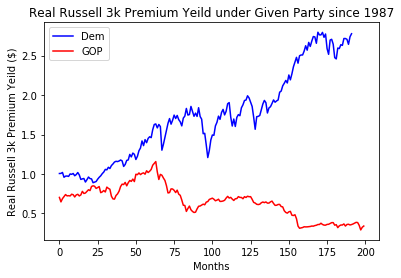

In [10]:
# Load up the Russell 3k
# source: https://finance.yahoo.com/quote/%5ERUA/history?p=%5ERUA
rus = pd.read_csv('^RUA.csv')[['Date','Adj Close']]
rus['Return'] = (rus['Adj Close']-rus['Adj Close'].shift(1))/rus['Adj Close']
rus = rus[1:-3].reset_index(drop=True)

# get russell market risk premium
rf3k = rf[-(rus.shape[0]+1):].reset_index(drop=True)
inf3k = inf.loc[-(rus.shape[0]+1):,'Inflation Rate']
rus['R3KRFI'] = (1 + rus['Return'] - rf3k)/(1 + inf3k) - 1
rus['R3KRF'] = rus['Return'] - rf3k


# get dem dummy
demY = list(range(1993,2001)) + list(range(2009,2017))
rus['Date'] = pd.to_datetime(rus['Date'])
rus['Dem'] = rus['Date'].dt.to_period('Y')

def demIn(s):
    if s.year in demY:
        return 1
    return 0

rus['Dem'] = rus['Dem'].map(demIn)

# split
drus = rus[rus['Dem'] == 1].reset_index(drop=True)
grus = rus[rus['Dem'] == 0].reset_index(drop=True)

# get dem expected return
drus['fv'] = 0
fv = 1

for index, row in drus.iterrows():
    fv = (fv*(1+row[rusprem]))
    drus.loc[index,'fv'] = fv

# get gop expected return
grus['fv'] = 0
fv = 1

for index, row in grus.iterrows():
    fv = (fv*(1+row[rusprem]))
    grus.loc[index,'fv'] = fv
    
# plot theoretical yeild
name = premiumstr + 'Russell 3k Premium'
plot(drus['fv'], color='blue', label='Dem')
plot(grus['fv'], color='red', label='GOP')
xlabel('Months')
ylabel(name + ' Yeild ($)')
title(name + ' Yeild under Given Party since 1987')
legend()

In [11]:
# build return table
rrus = pd.DataFrame([grus[rusprem].mean(), drus[rusprem].mean(), rus[rusprem].mean()])
rrus = rrus.rename(columns={0:name},index={0:'GOP',1:'Democrats',2:'Combined'})
rrus[name] = rrus[name].apply(lambda x: str(round(((1+x)**12-1)*100,2))+'%')

# add risk
rrus['Risk'] = [grus[rusprem].std(), drus[rusprem].std(), rus[rusprem].std()]
rrus['Risk'] = rrus['Risk'].apply(lambda x: str(round(x*sqrt(12)*100,2))+'%')

# output final table
rrus

,Real Russell 3k Premium,Risk
GOP,-4.66%,17.76%
Democrats,7.71%,14.32%
Combined,1.22%,16.24%


By using the Russel 3k, we expand our analysis to a wider range of market sectors (500 to 3000 securities). Thus, this index better represents the market in its entirety. Again, this analysis demonstrates better democratic performance.

## Conclusion

In conclusion, the economical prudent decision is to support the Democratic party as it increase returns and GDP while reducing the risk. This conclusion is based on and supported by the historical price patterns of the market (S&P500, Russell 3k) and real GDP, statistics, and monetary portfolio theory. All values adjusted for inflation and risk-free when applicable.